<a href="https://colab.research.google.com/github/sharmaparnika/Spam_Detection_Project/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING LIBRARIES

In [1]:
# import libraries for reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# library for train test split
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

### DATASET

In [2]:
url="https://raw.githubusercontent.com/ashishpatel26/Naive-Bayes-SMS-Spam-Collection/master/SMSSpamCollection"
messages = pd.read_csv(url, sep ='\t',names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


# LOADING AND EXPLORING DATA

In [3]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [5]:
messages.groupby('label').describe().T

label                              ham                                               spam
message count                     4825                                                747
        unique                    4516                                                653
        top     Sorry, I'll call later  Please call our customer service representativ...
        freq                        30                                                  4

In [6]:
messages["length"] = messages["message"].apply(len)
messages.sort_values(by='length', ascending=False).head(10)

,label,message,length
1085,ham,For me the love should start with attraction.i...,910
1863,ham,The last thing i ever wanted to do was hurt yo...,790
2434,ham,Indians r poor but India is not a poor country...,629
1579,ham,How to Make a girl Happy? It's not at all diff...,611
2158,ham,Sad story of a Man - Last week was my b'day. M...,588
2849,ham,Sad story of a Man - Last week was my b'day. M...,588
2380,ham,"Good evening Sir, hope you are having a nice d...",482
3017,ham,"&lt;#&gt; is fast approaching. So, Wish u a v...",461
1513,ham,"Hey sweet, I was wondering when you had a mome...",458
5104,ham,A Boy loved a gal. He propsd bt she didnt mind...,446


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f626b404110>,
      dtype=object)

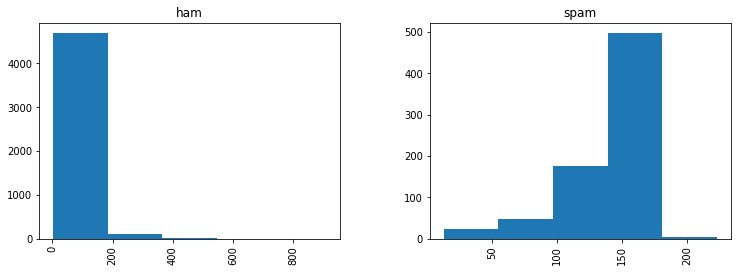

In [7]:
messages.hist(column = 'length', by ='label',figsize=(12,4), bins = 5)

In [8]:
# Get all the ham and spam sms
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

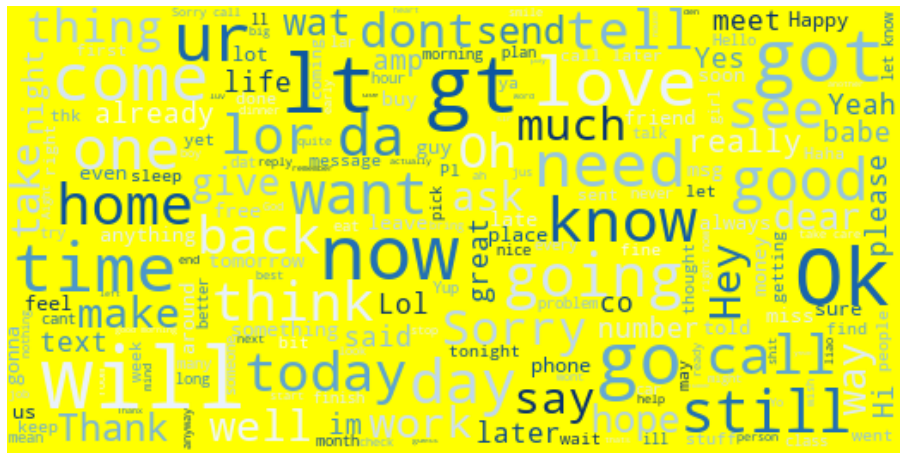

In [9]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="yellow", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

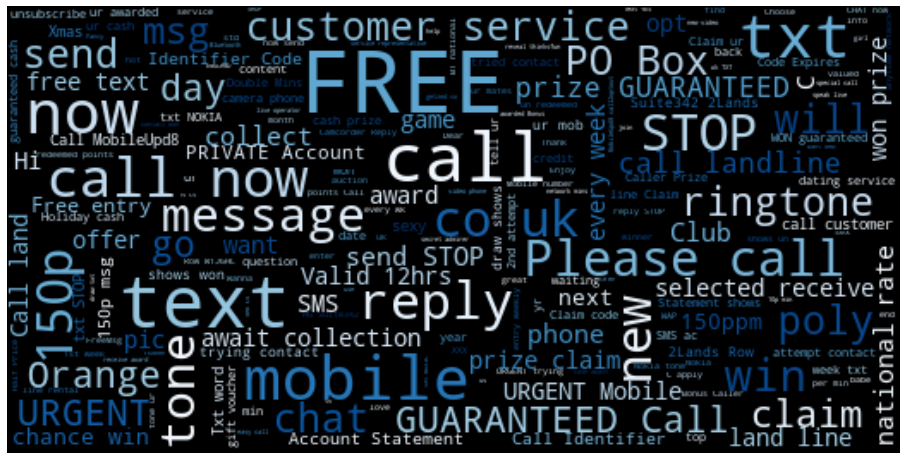

In [10]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

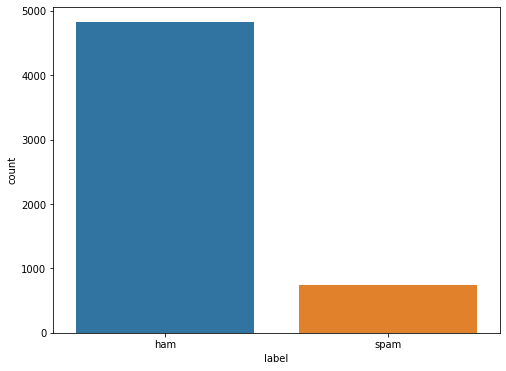

In [11]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(messages.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100 

In [12]:
# one way to fix it is to downsample the ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 3) (747, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

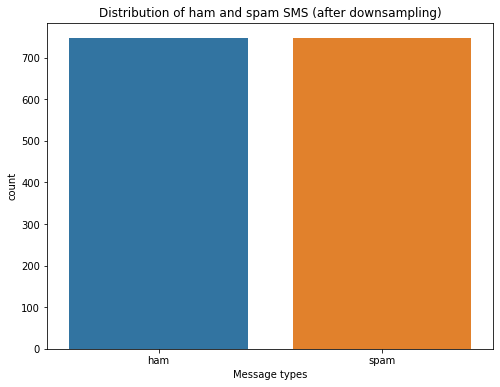

In [13]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam SMS (after downsampling)')
plt.xlabel('Message types')

In [14]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,length,text_length
label,,
ham,73.238286,73.238286
spam,138.670683,138.670683


# PREPARING DATA

### Splitting the data into training set and testing set

In [15]:
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

## Tokenization

In [16]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [17]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [18]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'u': 8,
 'your': 9,
 'for': 10,
 'is': 11,
 '2': 12,
 'and': 13,
 'now': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'ur': 19,
 'have': 20,
 '4': 21,
 'txt': 22,
 'of': 23,
 'are': 24,
 'with': 25,
 'me': 26,
 'from': 27,
 'text': 28,
 'get': 29,
 'my': 30,
 'it': 31,
 'stop': 32,
 'just': 33,
 'mobile': 34,
 'this': 35,
 'will': 36,
 'be': 37,
 'no': 38,
 'that': 39,
 'claim': 40,
 'reply': 41,
 'can': 42,
 'so': 43,
 'send': 44,
 'www': 45,
 'we': 46,
 'only': 47,
 'our': 48,
 'not': 49,
 'out': 50,
 'at': 51,
 'do': 52,
 'if': 53,
 'prize': 54,
 'new': 55,
 'go': 56,
 'cash': 57,
 'but': 58,
 '150p': 59,
 'uk': 60,
 '1': 61,
 'nokia': 62,
 'who': 63,
 't': 64,
 'all': 65,
 'win': 66,
 'please': 67,
 'won': 68,
 'up': 69,
 'tone': 70,
 'when': 71,
 "i'm": 72,
 'week': 73,
 'been': 74,
 'what': 75,
 'msg': 76,
 '50': 77,
 'com': 78,
 'urgent': 79,
 'how': 80,
 'service': 81,
 'phone': 82,
 'time': 83,
 

In [19]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)

There are 4169 unique tokens in training data. 


## Sequencing and padding on training and testing 

In [20]:
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [21]:
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [22]:
len(training_sequences[0]), len(training_sequences[1])

(27, 24)

In [23]:
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [24]:
print(training_padded[0])

[  1  47 186   9  34   1   3  24   1   2 274   2   7 152 275 135  34  10
  15   6   7  34 274  85  15  17   1   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# Dense Spam Detection Model

In [25]:
vocab_size = 500 
embeding_dim = 16
drop_value = 0.2 
n_dense = 24

In [26]:
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
______________________________________________________

In [28]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

### Training and evaluating the Dense model

In [29]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 1s - loss: 0.6882 - accuracy: 0.7238 - val_loss: 0.6801 - val_accuracy: 0.8060 - 1s/epoch - 32ms/step
Epoch 2/30
38/38 - 0s - loss: 0.6600 - accuracy: 0.8728 - val_loss: 0.6415 - val_accuracy: 0.8495 - 60ms/epoch - 2ms/step
Epoch 3/30
38/38 - 0s - loss: 0.6039 - accuracy: 0.8887 - val_loss: 0.5731 - val_accuracy: 0.8528 - 64ms/epoch - 2ms/step
Epoch 4/30
38/38 - 0s - loss: 0.5170 - accuracy: 0.8962 - val_loss: 0.4837 - val_accuracy: 0.8562 - 59ms/epoch - 2ms/step
Epoch 5/30
38/38 - 0s - loss: 0.4179 - accuracy: 0.8954 - val_loss: 0.3920 - val_accuracy: 0.8796 - 77ms/epoch - 2ms/step
Epoch 6/30
38/38 - 0s - loss: 0.3272 - accuracy: 0.9138 - val_loss: 0.3198 - val_accuracy: 0.8896 - 72ms/epoch - 2ms/step
Epoch 7/30
38/38 - 0s - loss: 0.2614 - accuracy: 0.9205 - val_loss: 0.2690 - val_accuracy: 0.8963 - 81ms/epoch - 2ms/step
Epoch 8/30
38/38 - 0s - loss: 0.2166 - accuracy: 0.9381 - val_loss: 0.2244 - val_accuracy: 0.9097 - 71ms/epoch - 2ms/step
Epoch 9/30
38/38 - 0s - l

In [30]:
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 1ms/step - loss: 0.1187 - accuracy: 0.9431


[0.11870698630809784, 0.9431437849998474]

In [31]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

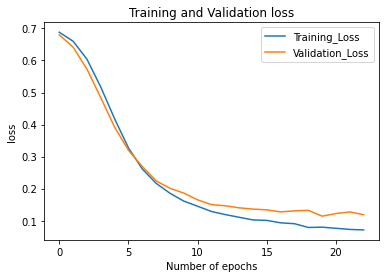

In [32]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

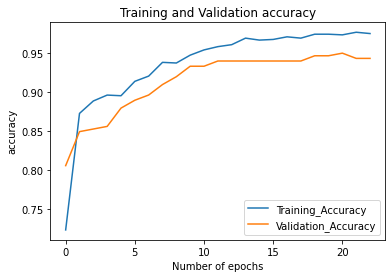

In [33]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# LSTM

In [34]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2
embeding_dim = 16

In [35]:
#LSTM Spam detection architecture
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

In [36]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [37]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            8000      
                                                                 
 lstm (LSTM)                 (None, 50, 20)            2960      
                                                                 
 lstm_1 (LSTM)               (None, 50, 20)            3280      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 15,241
Trainable params: 15,241
Non-trainable params: 0
_________________________________________________________________


In [38]:
import time
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 5s - loss: 0.5681 - accuracy: 0.7900 - val_loss: 0.4555 - val_accuracy: 0.8060 - 5s/epoch - 135ms/step
Epoch 2/30
38/38 - 1s - loss: 0.2242 - accuracy: 0.9079 - val_loss: 0.1774 - val_accuracy: 0.9298 - 1s/epoch - 31ms/step
Epoch 3/30
38/38 - 1s - loss: 0.1228 - accuracy: 0.9582 - val_loss: 0.1405 - val_accuracy: 0.9465 - 1s/epoch - 31ms/step
Epoch 4/30
38/38 - 1s - loss: 0.0870 - accuracy: 0.9690 - val_loss: 0.2178 - val_accuracy: 0.9331 - 1s/epoch - 32ms/step
Epoch 5/30
38/38 - 1s - loss: 0.0704 - accuracy: 0.9715 - val_loss: 0.1326 - val_accuracy: 0.9532 - 1s/epoch - 31ms/step
Epoch 6/30
38/38 - 1s - loss: 0.0478 - accuracy: 0.9799 - val_loss: 0.1475 - val_accuracy: 0.9498 - 1s/epoch - 30ms/step
Epoch 7/30
38/38 - 1s - loss: 0.0481 - accuracy: 0.9841 - val_loss: 0.1959 - val_accuracy: 0.9398 - 1s/epoch - 31ms/step


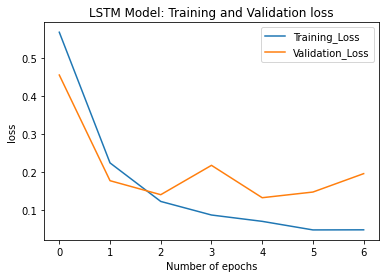

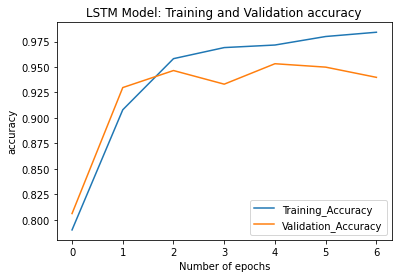

In [39]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [40]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

# BiLSTM

In [41]:
# Biderectional LSTM Spam detection architecture
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling2D
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [42]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [43]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
38/38 - 5s - loss: 0.5522 - accuracy: 0.7816 - val_loss: 0.3924 - val_accuracy: 0.8161 - 5s/epoch - 124ms/step
Epoch 2/30
38/38 - 1s - loss: 0.2126 - accuracy: 0.9213 - val_loss: 0.1951 - val_accuracy: 0.9298 - 912ms/epoch - 24ms/step
Epoch 3/30
38/38 - 1s - loss: 0.1274 - accuracy: 0.9565 - val_loss: 0.1394 - val_accuracy: 0.9398 - 907ms/epoch - 24ms/step
Epoch 4/30
38/38 - 1s - loss: 0.0946 - accuracy: 0.9674 - val_loss: 0.1399 - val_accuracy: 0.9365 - 914ms/epoch - 24ms/step
Epoch 5/30
38/38 - 1s - loss: 0.0737 - accuracy: 0.9724 - val_loss: 0.1411 - val_accuracy: 0.9532 - 907ms/epoch - 24ms/step


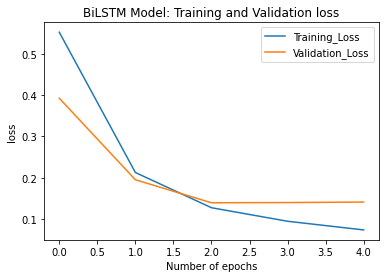

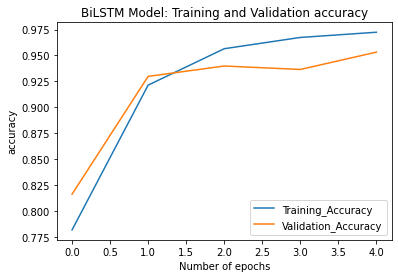

In [44]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# Predicting messages

In [45]:
pd.options.display.max_colwidth=100
messages[:3]

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...,155


In [46]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"]

### Dense

In [47]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

array([[0.01605108],
       [0.01011851],
       [0.9998365 ]], dtype=float32)

### LSTM

In [48]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model1.predict(padded))
predict_spam(predict_msg)

array([[3.3918917e-03],
       [9.7921491e-04],
       [9.9999905e-01]], dtype=float32)

### BiLSTM

In [49]:
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model2.predict(padded))
predict_spam(predict_msg)

array([[0.01060849],
       [0.00185883],
       [0.99999475]], dtype=float32)

## PREDICT TEXT HERE

In [50]:
predict_msg = [" IEEE based Mini / Major Project List FREE Download link FYR ",
               "How are you",
          "You won a free lottery! Click here to download reciept"]
predict_spam(predict_msg)

array([[0.09272772],
       [0.00407782],
       [0.9892117 ]], dtype=float32)

# Comparing three different models

In [51]:

print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

10/10 [==============================] - 0s 1ms/step - loss: 0.1187 - accuracy: 0.9431
Dense architecture loss and accuracy: [0.11870698630809784, 0.9431437849998474] 
10/10 [==============================] - 0s 8ms/step - loss: 0.1959 - accuracy: 0.9398
LSTM architecture loss and accuracy: [0.19593626260757446, 0.9397993087768555] 
10/10 [==============================] - 0s 6ms/step - loss: 0.1411 - accuracy: 0.9532
Bi-LSTM architecture loss and accuracy: [0.14109092950820923, 0.953177273273468] 


---------